## TORCHAUDIO TUTORIAL
PyTorch is an open source deep learning platform that provides a seamless path from research prototyping to production deployment with GPU support.

Significant effort in solving machine learning problems goes into data preparation. torchaudio leverages PyTorch’s GPU support, and provides many tools to make data loading easy and more readable. In this tutorial, we will see how to load and preprocess data from a simple dataset.

For this tutorial, please make sure the matplotlib package is installed for easier visualization.

In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt


## Opening a dataset
torchaudio supports loading sound files in the wav and mp3 format. We call waveform the resulting raw audio signal.

Shape of waveform: torch.Size([1, 271872])
Sample rate of waveform: 44100


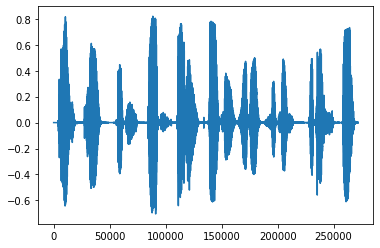

In [3]:
filename = "Record.mp3"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

## Transformations
torchaudio supports a growing list of [transformations](https://pytorch.org/audio/transforms.html).

- Resample: Resample waveform to a different sample rate.
- Spectrogram: Create a spectrogram from a waveform.
- MelScale: This turns a normal STFT into a Mel-frequency STFT, using a conversion matrix.
- AmplitudeToDB: This turns a spectrogram from the power/amplitude scale to the decibel scale.
- MFCC: Create the Mel-frequency cepstrum coefficients from a waveform.
- MelSpectrogram: Create MEL Spectrograms from a waveform using the STFT function in PyTorch.
- MuLawEncoding: Encode waveform based on mu-law companding.
- MuLawDecoding: Decode mu-law encoded waveform.

Since all transforms are nn.Modules or jit.ScriptModules, they can be used as part of a neural network at any point.
<br/><br/>
To start, we can look at the log of the spectrogram on a log scale.

Spectrogram on a log scale

Shape of spectogram: torch.Size([1, 201, 1360])
Shape of spectogram[0,...]: torch.Size([201, 1360])


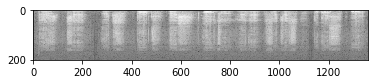

In [4]:
# spectrogram on a log scale
spectogram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectogram: {}".format(spectogram.size()))
print("Shape of spectogram[0,...]: {}".format(spectogram[0,...].size()))

plt.figure()
plt.imshow(spectogram.log2()[0,...].numpy(), cmap='gray')

Mel Spectrogram on a log scale

Shape of spectogram: torch.Size([1, 128, 1360])
Shape of spectogram[0,...]: torch.Size([128, 1360])


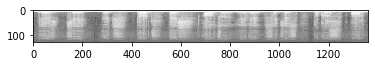

In [5]:
# Mel Spectrogram on a log scale
spectogram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectogram: {}".format(spectogram.size()))
print("Shape of spectogram[0,...]: {}".format(spectogram[0,...].size()))

plt.figure()
p = plt.imshow(spectogram.log2()[0, ...].detach().numpy(), cmap='gray')



Resample the waveform, one channel at a time

Shape of spectogram: torch.Size([1, 128, 1360])
Shape of spectogram[0,...]: torch.Size([128, 1360])


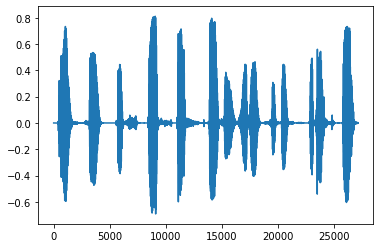

In [6]:
# Resample the waveform, one channel at a time
new_sample_rate = sample_rate/10
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of spectogram: {}".format(spectogram.size()))
print("Shape of spectogram[0,...]: {}".format(spectogram[channel,...].size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

In [7]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))



Min of waveform: -0.7043114304542542
Max of waveform: 0.8201488852500916
Mean of waveform: -7.085666584316641e-05


Since the waveform is already between -1 and 1, we do not need to normalize it.

In [8]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)

Shape of transformed waveform: torch.Size([1, 271872])


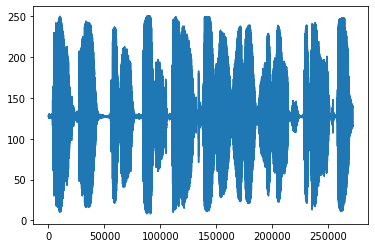

In [9]:
encoded = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(encoded.size()))

plt.figure()
plt.plot(encoded[0,:].numpy())

Shape of transformed waveform: torch.Size([1, 271872])


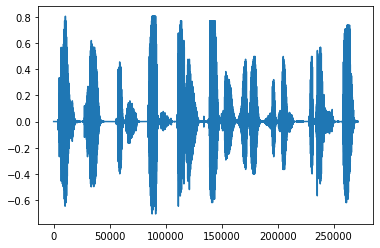

In [10]:
decoded = torchaudio.transforms.MuLawDecoding()(encoded)

print("Shape of transformed waveform: {}".format(decoded.size()))

plt.figure()
plt.plot(decoded[0,:].numpy())

error between encoded and decoded

In [11]:
err = ((waveform-decoded).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 1.83%


# Kaldi
## Migrating to torchaudio from Kaldi
Users may be familiar with [Kaldi](https://github.com/kaldi-asr/kaldi), a toolkit for speech recognition. torchaudio offers compatibility with it in torchaudio.kaldi_io. It can indeed read from kaldi scp, or ark file or streams with:
- read_vec_int_ark
- read_vec_flt_scp
- read_vec_flt_arkfile/stream
- read_mat_scp
- read_mat_ark

torchaudio provides Kaldi-compatible transforms for spectrogram and fbank with the benefit of GPU support, see here for more information.

Shape of spectogram: torch.Size([1358, 201])


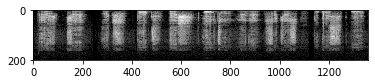

In [13]:
n_fft = 400.0
frame_lenght = n_fft / sample_rate * 1000.0
frame_shift = frame_lenght / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_lenght,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

spectogram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print('Shape of spectogram: {}'.format(spectogram.size()))

plt.figure()
plt.imshow(spectogram.t().numpy(), cmap='gray')

filterbank features from waveforms, matching Kaldi’s implementation

Shape of size: torch.Size([1358, 23])


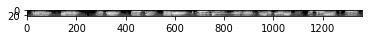

In [14]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print('Shape of size: {}'.format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray')